In [5]:
from inst_sol import *
from evaluator import *

In [2]:
import numpy as np
from scipy.ndimage import distance_transform_edt
from skimage.draw import line
import matplotlib.pyplot as plt

def get_covered_nodes(grid_shape, path_points, sprayer_length):
    """
    Calculates grid coverage using a distance transform.

    Args:
        grid_shape (tuple): The (rows, cols) shape of the field grid.
        path_points (list): A list of (row, col) integer tuples defining the path.
        sprayer_length (float): The total length/width of the sprayer's coverage.

    Returns:
        numpy.ndarray: A boolean grid where `True` indicates a covered node.
    """
    # 1. RASTERIZE THE PATH: Create a grid and draw the path segments on it.
    # Initialize a boolean grid, where we'll mark the path.
    path_grid = np.zeros(grid_shape, dtype=bool)
    
    # Iterate through consecutive pairs of points in the path.
    for i in range(len(path_points) - 1):
        # Get the start and end points of the current segment.
        p1 = path_points[i]
        p2 = path_points[i+1]
        
        # Use a line-drawing algorithm to find all grid cells on this segment.
        rr, cc = line(r0=p1[0], c0=p1[1], r1=p2[0], c1=p2[1])
        
        # Mark these cells as `True` on our path grid.
        # This works even if the points are far apart.
        path_grid[rr, cc] = True

    # 2. COMPUTE THE DISTANCE TRANSFORM: Calculate each node's distance to the path.
    # The `edt` (Euclidean Distance Transform) function is perfect for this.
    # It calculates the distance from each `False` element to the nearest `True` element.
    # We must invert the grid (`~path_grid`) for the function to work as intended.
    distances = distance_transform_edt(~path_grid)

    # 3. THRESHOLD TO FIND COVERAGE: Select nodes within the sprayer's reach.
    # The sprayer covers an area up to half its length from the center line (the path).
    coverage_grid = distances <= (sprayer_length / 2.0)
    
    return coverage_grid

# --- EXAMPLE USAGE ---
if __name__ == '__main__':
    # Define a 200x300 grid for our field.
    my_grid_shape = (200, 300)
    
    # Define a path with non-adjacent nodes.
    my_path = [(20, 20), (50, 280), (180, 250), (150, 30)]
    
    # Define a sprayer that is 30 units long.
    my_sprayer_length = 15
    
    # Calculate the coverage map.
    coverage_map = get_covered_nodes(my_grid_shape, my_path, my_sprayer_length)
    
    # --- Visualization (Optional) ---
    # Use Matplotlib to display the result.
    print(f"Grid Shape: {my_grid_shape}")
    print(f"Covered Nodes: {np.sum(coverage_map)}")
    
    plt.figure(figsize=(9, 6))
    plt.imshow(coverage_map, cmap='gray', interpolation='nearest')
    plt.title('Covered Area (Shown in White)')
    plt.xlabel('Grid Columns')
    plt.ylabel('Grid Rows')
    plt.show()

Grid Shape: (200, 300)
Covered Nodes: 9654


<Figure size 900x600 with 1 Axes>

Total valid nodes in shape: 26404
Total covered nodes: 2988


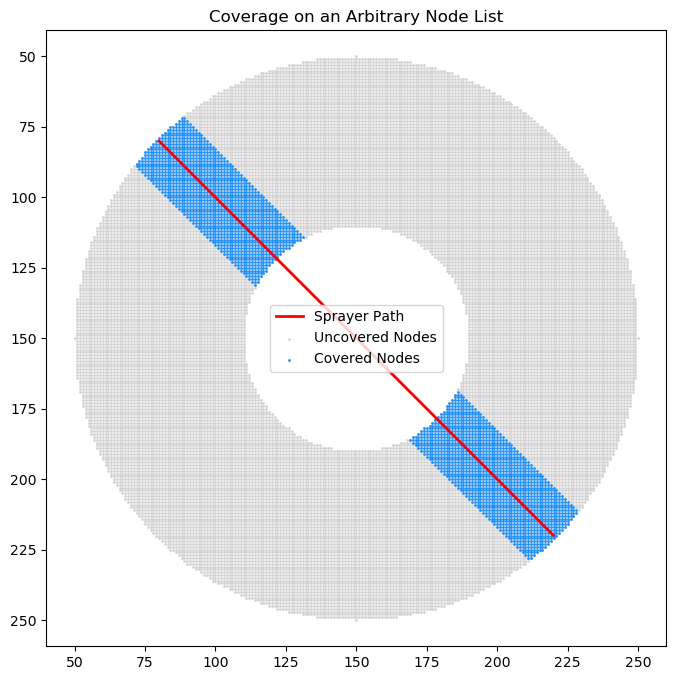

In [3]:
import numpy as np
from scipy.ndimage import distance_transform_edt
from skimage.draw import line
import matplotlib.pyplot as plt

def get_covered_nodes(grid_shape, path_points, sprayer_length):
    """Calculates coverage on a rectangular grid. (Unchanged from before)."""
    path_grid = np.zeros(grid_shape, dtype=bool)
    for i in range(len(path_points) - 1):
        p1, p2 = path_points[i], path_points[i+1]
        rr, cc = line(r0=p1[0], c0=p1[1], r1=p2[0], c1=p2[1])
        # Ensure path points are within the grid bounds
        valid_idx = (rr >= 0) & (rr < grid_shape[0]) & (cc >= 0) & (cc < grid_shape[1])
        path_grid[rr[valid_idx], cc[valid_idx]] = True
    distances = distance_transform_edt(~path_grid)
    return distances <= (sprayer_length / 2.0)

def get_nodelist_coverage(node_list, path_points, sprayer_length):
    """
    Calculates sprayer coverage for a dense, evenly-spaced list of nodes.

    Args:
        node_list (list or np.array): A list of valid (row, col) node coordinates.
        path_points (list or np.array): A list of (row, col) path coordinates.
        sprayer_length (float): The width of the sprayer.

    Returns:
        np.array: An array of the (row, col) coordinates of covered nodes.
    """
    # Ensure inputs are NumPy arrays for efficient operations
    nodes_arr = np.array(node_list)
    path_arr = np.array(path_points)

    # 1. FIND BOUNDING BOX and coordinate offset
    min_coords = np.min(nodes_arr, axis=0)
    max_coords = np.max(nodes_arr, axis=0)
    
    # The shape of our temporary rectangular grid
    grid_shape = max_coords - min_coords + 1

    # 2. CREATE VALIDITY MASK from the node list
    validity_mask = np.zeros(grid_shape, dtype=bool)
    # Offset the node coordinates to fit in the new grid
    shifted_nodes = nodes_arr - min_coords
    # Use advanced indexing to efficiently "stamp" the nodes onto the mask
    validity_mask[shifted_nodes[:, 0], shifted_nodes[:, 1]] = True

    # 3. RUN COVERAGE ALGORITHM on the rectangular grid
    # Shift the path coordinates to the temporary grid's coordinate system
    shifted_path = path_arr - min_coords
    rectangular_coverage = get_covered_nodes(grid_shape, shifted_path, sprayer_length)
    
    # 4. APPLY MASK and convert results back
    final_coverage_mask = rectangular_coverage & validity_mask
    
    # Find the indices of the covered nodes in the temporary grid
    covered_indices_shifted = np.argwhere(final_coverage_mask)
    
    # Convert these indices back to the original coordinate system
    covered_nodes_original = covered_indices_shifted + min_coords
    
    return covered_nodes_original

# --- EXAMPLE USAGE ---
if __name__ == '__main__':
    # Create a complex shape: a large circle with a smaller circle cut out (a donut)
    center_r, center_c = 150, 150
    outer_radius, inner_radius = 100, 40
    
    # Generate all points for a 300x300 square
    r, c = np.mgrid[0:300, 0:300]
    # Calculate distance from the center
    dist_from_center = np.sqrt((r - center_r)**2 + (c - center_c)**2)
    
    # Keep only the points that form the donut shape
    donut_nodes = np.argwhere((dist_from_center <= outer_radius) & (dist_from_center >= inner_radius))
    
    # Define a path that cuts across the shape
    my_path = [(80, 80), (220, 220)]
    my_sprayer_len = 25

    # Get the final list of covered nodes
    covered_nodes = get_nodelist_coverage(donut_nodes, my_path, my_sprayer_len)
    
    print(f"Total valid nodes in shape: {len(donut_nodes)}")
    print(f"Total covered nodes: {len(covered_nodes)}")
    
    # --- Visualization ---
    plt.figure(figsize=(8, 8))
    # Plot all valid nodes in light gray
    plt.scatter(donut_nodes[:, 1], donut_nodes[:, 0], c='lightgray', s=1, label='Uncovered Nodes')
    # Plot the covered nodes in a distinct color
    if len(covered_nodes) > 0:
        plt.scatter(covered_nodes[:, 1], covered_nodes[:, 0], c='dodgerblue', s=1, label='Covered Nodes')
    # Plot the path
    path_arr = np.array(my_path)
    plt.plot(path_arr[:, 1], path_arr[:, 0], 'r-', lw=2, label='Sprayer Path')
    plt.gca().invert_yaxis() # Match array indexing for rows
    plt.axis('equal')
    plt.legend()
    plt.title('Coverage on an Arbitrary Node List')
    plt.show()

In [13]:
inst = AgcspInstance(donut_nodes, 10)
evaluator = AgcspEvaluator(inst)

In [16]:
my_path = [(80, 80), (200, 200), (10, 80)]
evaluator.calculate_coverage_proportion(my_path)

0.06817148916830783

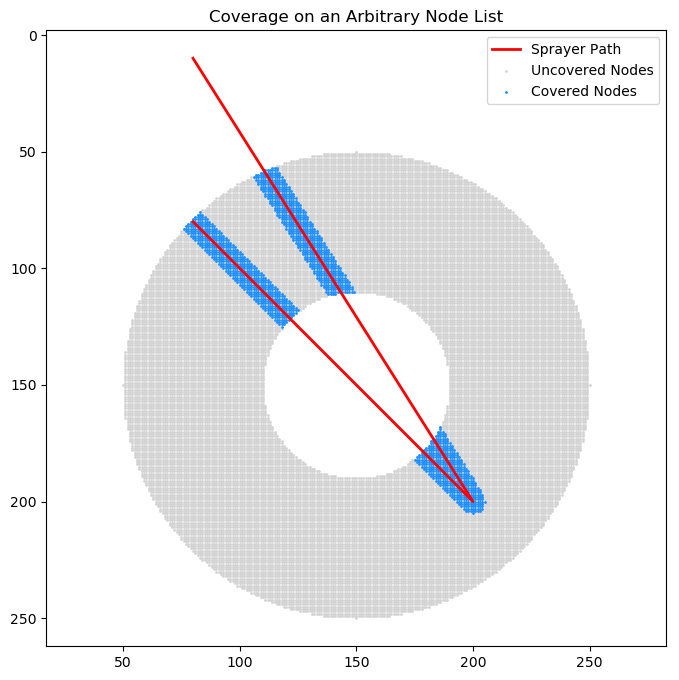

In [17]:
covered_nodes = evaluator.get_covered_nodes_list(my_path)
# --- Visualization ---
plt.figure(figsize=(8, 8))
# Plot all valid nodes in light gray
plt.scatter(inst.grid_nodes[:, 1], inst.grid_nodes[:, 0], c='lightgray', s=1, label='Uncovered Nodes')
# Plot the covered nodes in a distinct color
if len(covered_nodes) > 0:
    plt.scatter(covered_nodes[:, 1], covered_nodes[:, 0], c='dodgerblue', s=1, label='Covered Nodes')
# Plot the path
path_arr = np.array(my_path)
plt.plot(path_arr[:, 1], path_arr[:, 0], 'r-', lw=2, label='Sprayer Path')
plt.gca().invert_yaxis() # Match array indexing for rows
plt.axis('equal')
plt.legend()
plt.title('Coverage on an Arbitrary Node List')
plt.show()